In [34]:
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import time
import numpy as np
from sklearn.decomposition import PCA
import re
from sklearn.manifold import TSNE

# --- Configuration ---
FILE_PATH = 'flipkart_com-ecommerce_sample_1050.csv'
NUM_CLUSTERS = 21
BATCH_SIZE = 16
N_COMPONENTS_PCA = 384

In [35]:
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score , silhouette_score, normalized_mutual_info_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Téléchargement des ressources NLTK nécessaires (après avoir installé nltk lui-même)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

try:
    df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")
    print("Dataset chargé avec succès.")
except FileNotFoundError:
    print("Erreur: Le fichier 'flipkart_com-ecommerce_sample_1050.csv' n'a pas été trouvé. Assurez-vous qu'il est dans le même répertoire ou spécifiez le chemin correct.")
    exit()

# Nettoyage des noms de colonnes pour faciliter l'accès
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True)

# Vérifier la colonne de catégorie réelle
if 'product_category_tree' in df.columns:
    df['main_category'] = df['product_category_tree'].apply(
        lambda x: x.split('>>')[1].strip().lstrip('["').rstrip('"]') if pd.notna(x) else 'Unknown'
    )
    print("\nRépartition des catégories principales :")
    print(df['main_category'].value_counts())
else:
    print("La colonne 'product_category_tree' est manquante. Impossible d'extraire les catégories.")
    exit()

# Vérifier la colonne de description et de nom du produit
if 'description' not in df.columns:
    print("La colonne 'description' est manquante. Impossible de traiter les textes.")
    exit()
if 'product_name' not in df.columns:
    print("La colonne 'product_name' est manquante. Impossible de traiter les noms de produits.")
    exit()

# Supprimer les lignes avec des valeurs manquantes dans les colonnes critiques
df.dropna(subset=['description', 'main_category'], inplace=True)
# Fill NaN for product_name
df['product_name'] = df['product_name'].fillna('')
print(f"\nShape du dataset après suppression des NaNs : {df.shape}")

def preprocess_text_with_stemming(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)

    stop_words_set = set(stopwords.words('english'))

    # Initialisation du stemmer
    stemmer = PorterStemmer()

    processed_tokens = []
    for word in tokens:
        if word not in stop_words_set and len(word) > 2:
            stemmed_word = stemmer.stem(word)
            processed_tokens.append(stemmed_word)

    return ' '.join(processed_tokens)

# Fonction de prétraitement de texte
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Fonction de visualisation TSNE
def TSNE_visu_fct(X_tsne, y_true, labels, ari_score, title_prefix="Visualisation 2D des catégories (t-SNE)"):
    plt.figure(figsize=(12, 12))
    # Utilisation d'un colormap avec suffisamment de couleurs pour toutes les catégories
    cmap = plt.cm.get_cmap('tab20', len(labels)) if len(labels) <= 20 else plt.cm.get_cmap('tab20c', len(labels))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_true, cmap=cmap, s=10, alpha=0.6)

    # légende
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=label)
               for i, label in enumerate(labels)]
    plt.legend(handles=handles, title="Catégorie réelle", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"{title_prefix} - ARI: {ari_score:.4f}")
    plt.xlabel("Composante 1")
    plt.ylabel("Composante 2")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

category_counts = df['main_category'].value_counts()
single_item_categories = category_counts[category_counts < 3].index

if not single_item_categories.empty:
    df_filtered = df[~df['main_category'].isin(single_item_categories)].copy()
    print(f"\nNombre de catégories avec un seul article supprimées : {len(single_item_categories)}")
    print(f"Catégories avec un seul article supprimées : {list(single_item_categories)}")
    print(f"Shape du dataset après suppression des catégories à un seul article : {df_filtered.shape}")
    df = df_filtered
else:
    print("\nAucune catégorie avec un seul article n'a été trouvée.")

# Recalculer les variables nécessaires après le filtrage si le DataFrame a été modifié
unique_categories = df['main_category'].unique()
category_to_num = {cat: i for i, cat in enumerate(unique_categories)}
y_cat_num = df['main_category'].map(category_to_num).values
n_clusters = len(unique_categories)


Dataset chargé avec succès.

Répartition des catégories principales :
main_category
Wrist Watches                      149
Laptop Accessories                  87
Infant Wear                         84
Coffee Mugs                         74
Showpieces                          71
                                  ... 
Consumables & Disposables            1
TRUE Home Decor & Festive Needs      1
JMD Home Furnishing                  1
Kripa's Home Furnishing              1
Beauty Accessories                   1
Name: count, Length: 62, dtype: int64

Shape du dataset après suppression des NaNs : (1050, 16)

Nombre de catégories avec un seul article supprimées : 21
Catégories avec un seul article supprimées : ['Computer Components', 'Laptops', 'Eye Care', 'Storage', 'Furniture & Furnishings', 'Dinnerware & Crockery', 'Garden & Leisure', 'Clocks', 'Housekeeping & Laundry', "Men's Grooming", "Women's Hygiene", 'Pressure Cookers & Pans', 'Tidy Home Furnishing', 'Strollers & Activity Gear', 'Sof

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ilkanyilmaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ilkanyilmaz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilkanyilmaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ilkanyilmaz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
from transformers import AutoModel, AutoTokenizer
import torch
import time

# --- Charger le modèle pour générer les embeddings ---
MODEL_NAME = "thenlper/gte-base"

print(f"\nChargement du tokenizer et du modèle : {MODEL_NAME}...")
start_time_model_load = time.time()

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # optimisation pour le lancement en local
    # détecter le périphérique Apple Silicon (MPS)
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Utilisation du périphérique : MPS (Apple Silicon GPU)")
    else:
        device = torch.device("cpu")
        print("MPS non disponible, utilisation du CPU. Performances fortement réduites!")

    model = AutoModel.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    model.eval()
    print(f"Modèle chargé en {time.time() - start_time_model_load:.2f} secondes sur {model.device}.")

except Exception as e:
    print(f"Erreur lors du chargement du modèle GTE : {e}")
    print("Vérifiez la disponibilité du modèle et la configuration de l'environnement (ex: PyTorch avec MPS).")
    print("Essayez de décommenter `load_in_8bit=True` ou `load_in_4bit=True` si vous manquez de mémoire, mais notez que `bitsandbytes` n'est pas compatible MPS.")
    exit()


Chargement du tokenizer et du modèle : thenlper/gte-base...
Utilisation du périphérique : MPS (Apple Silicon GPU)
Modèle chargé en 0.67 secondes sur mps:0.


In [37]:
df['combined_text'] = (df['product_name'] + ' ' + df['description']
                        + ' ' + df['product_category_tree'])

print("Prétraitement des textes combinés (nom et description)...")
df['processed_combined_text'] = df['combined_text'].apply(preprocess_text)
print("Prétraitement terminé.")
print(df[['product_name', 'description', 'processed_combined_text']].head())

Prétraitement des textes combinés (nom et description)...
Prétraitement terminé.
                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                             processed_combined_text  
0  elegance polyester multicolor abstract eyelet ...  
1  sathiyas cotton bath towel specification sathi...  
2  eurospa cotton terry face towel set key featur...  
3  santosh royal fashion 

In [38]:
from tqdm.auto import tqdm
import torch
import numpy as np

# --- Fonction pour obtenir les embeddings (améliorée avec normalisation L2 et logs) ---
def get_model_embeddings(texts, model, tokenizer, device, batch_size=16):
    embeddings = []
    # tqdm pour envelopper l'itérateur du lot
    for i in tqdm(range(0, len(texts), batch_size), desc="Génération des embeddings"):
        batch_texts = texts[i:i + batch_size]

        # Vérification et conversion explicite au cas où certains éléments ne seraient pas str
        batch_texts = [str(t) for t in batch_texts]

        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            last_hidden_states = outputs.last_hidden_state

            attention_mask = inputs['attention_mask'].unsqueeze(-1).float()
            pooled_embeddings = torch.sum(last_hidden_states * attention_mask, dim=1) / torch.clamp(attention_mask.sum(1), min=1e-9)

            batch_embeddings = torch.nn.functional.normalize(pooled_embeddings, p=2, dim=1).cpu().numpy()

            embeddings.extend(batch_embeddings)
    return np.array(embeddings)

print("\nGénération des embeddings avec GTE (sur texte combiné)...")
start_time_embedding = time.time()

texts = df['processed_combined_text'].tolist()
model_embeddings = get_model_embeddings(texts, model, tokenizer, device, BATCH_SIZE)
print(f"Embeddings générés en {time.time() - start_time_embedding:.2f} secondes. Forme : {model_embeddings.shape}")


Génération des embeddings avec GTE (sur texte combiné)...


Génération des embeddings: 100%|██████████| 64/64 [00:14<00:00,  4.43it/s]

Embeddings générés en 14.46 secondes. Forme : (1024, 768)


In [39]:
# --- Réduction de dimensionnalité avec PCA ---
print(f"\nRéduction de la dimensionnalité des embeddings GTE avec PCA à {N_COMPONENTS_PCA} composants...")
start_time_pca = time.time()
pca = PCA(n_components=N_COMPONENTS_PCA, random_state=42)
model_embeddings_processed = pca.fit_transform(model_embeddings)
print(f"PCA terminée en {time.time() - start_time_pca:.2f} secondes. Nouvelle forme : {model_embeddings_processed.shape}")



Réduction de la dimensionnalité des embeddings GTE avec PCA à 384 composants...
PCA terminée en 0.14 secondes. Nouvelle forme : (1024, 384)


In [40]:
# --- Visualisation t-SNE pour GTE ---
print("\nCalcul t-SNE pour les embeddings GTE...")
current_perplexity_model = min(30, model_embeddings_processed.shape[0] - 1)
if current_perplexity_model <= 0:
    print("Pas assez d'échantillons pour calculer t-SNE avec la perplexité requise pour GTE.")
    X_tsne_model = None
else:
    tsne_model = TSNE(n_components=2, random_state=42, perplexity=current_perplexity_model, n_iter=250, verbose=True)
    model_tsne_start_time = time.time()
    X_tsne_model = tsne_model.fit_transform(model_embeddings_processed)
    model_tsne_duration = time.time() - model_tsne_start_time
    print(f"t-SNE pour GTE terminé en {model_tsne_duration:.2f} secondes.")



Calcul t-SNE pour les embeddings GTE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.001s...
[t-SNE] Computed neighbors for 1024 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 0.186498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.075970
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000
t-SNE pour GTE terminé en 0.54 secondes.


In [41]:
# --- Appliquer l'algorithme de clustering (MiniBatchKMeans) ---
print(f"\nApplication de MiniBatchKMeans avec {len(unique_categories)} clusters sur les embeddings traités GTE...")
start_time_clustering = time.time()

kmeans_model = MiniBatchKMeans(n_clusters=len(unique_categories), random_state=42, n_init=10, verbose=True)
clusters_model = kmeans_model.fit_predict(model_embeddings_processed)
print(f"Clustering terminé en {time.time() - start_time_clustering:.2f} secondes.")


Application de MiniBatchKMeans avec 41 clusters sur les embeddings traités GTE...
Init 1/10 with method k-means++
Inertia for init 1/10: 194.56686401367188
Init 2/10 with method k-means++
Inertia for init 2/10: 201.6772918701172
Init 3/10 with method k-means++
Inertia for init 3/10: 194.4980010986328
Init 4/10 with method k-means++
Inertia for init 4/10: 199.22801208496094
Init 5/10 with method k-means++
Inertia for init 5/10: 190.0072479248047
Init 6/10 with method k-means++
Inertia for init 6/10: 200.12818908691406
Init 7/10 with method k-means++
Inertia for init 7/10: 194.6519012451172
Init 8/10 with method k-means++
Inertia for init 8/10: 197.18994140625
Init 9/10 with method k-means++
Inertia for init 9/10: 195.52883911132812
Init 10/10 with method k-means++
Inertia for init 10/10: 194.4068603515625
Minibatch step 1/100: mean batch inertia: 0.18811282515525818
Minibatch step 2/100: mean batch inertia: 0.11635519564151764, ewa inertia: 0.11635519564151764
Minibatch step 3/100: mea


Calcul des métriques de performance pour GTE...
Silhouette Score (GTE) : 0.1430

Colonnes de 'vraies étiquettes' traitées depuis 'product_category_tree' vers 'main_category'.
Nombre de classes réelles uniques : 42
Adjusted Rand Index (ARI) (GTE) : 0.5099
Normalized Mutual Information (NMI) (GTE) : 0.7926

Durée totale de l'opération (GTE, incluant chargement, embedding, PCA, clustering) : 16.58 secondes.


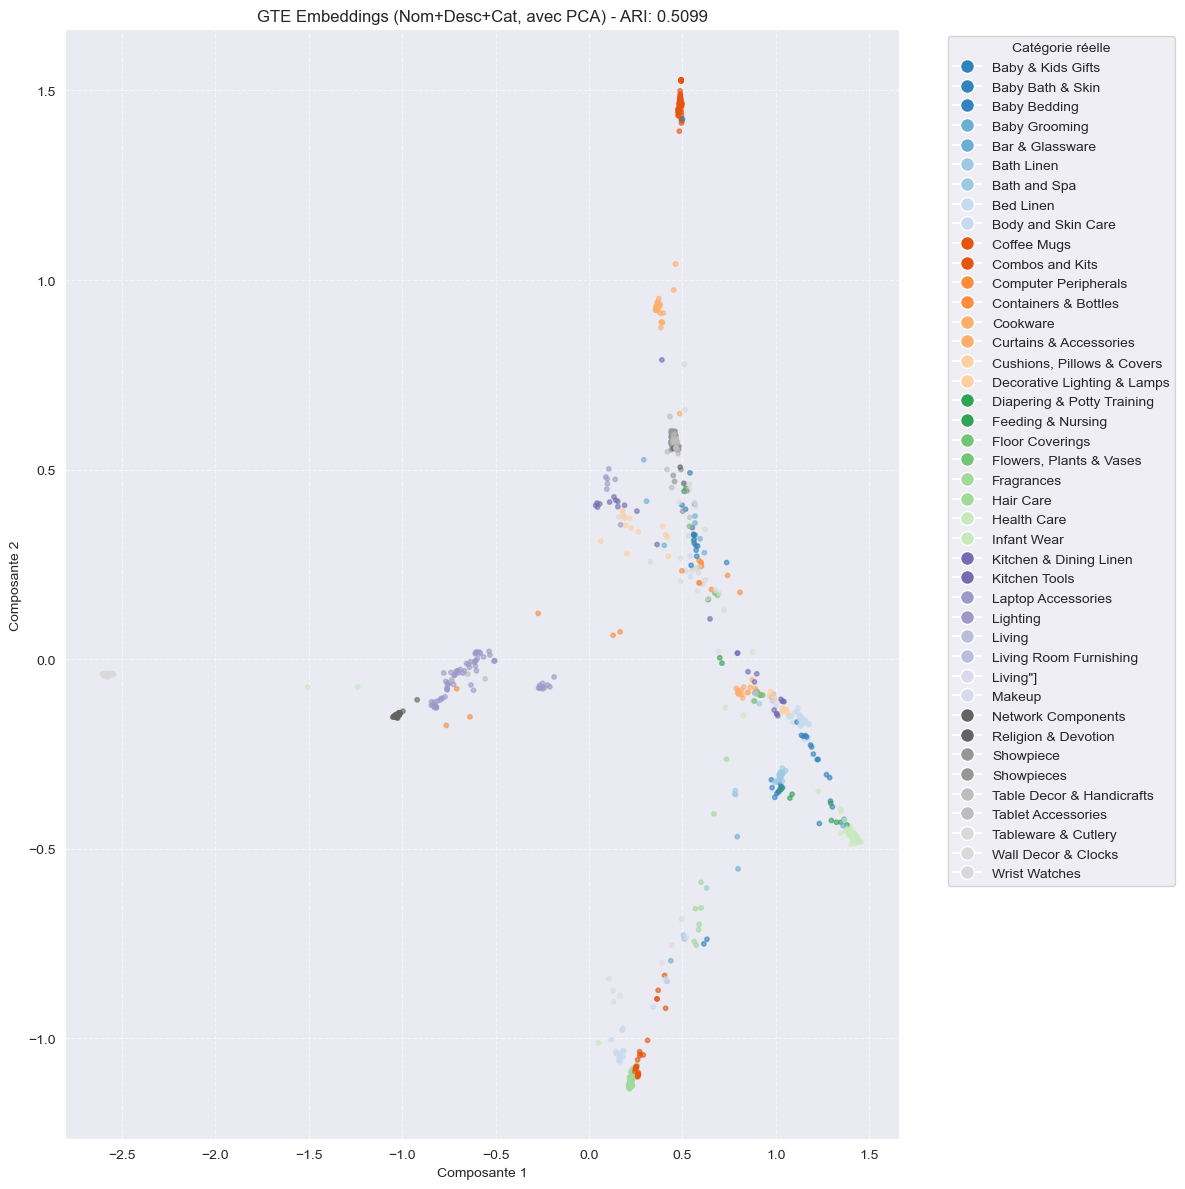

In [42]:
# --- Calculer les métriques pour GTE ---
print("\nCalcul des métriques de performance pour GTE...")

silhouette_model = 0.0
# Assurez-vous d'avoir au moins 2 clusters formés pour calculer le silhouette score
if len(set(clusters_model)) > 1:
    silhouette_model = silhouette_score(model_embeddings_processed, clusters_model)
    print(f"Silhouette Score (GTE) : {silhouette_model:.4f}")
else:
    print("Le score de Silhouette ne peut pas être calculé pour GTE (moins de 2 clusters formés).")

ari_model = float('nan')
nmi_model = float('nan')

TRUE_LABELS_COLUMN = 'product_category_tree'
TRUE_LABELS_PROCESSED_COLUMN = 'main_category'

true_labels_present = False
if TRUE_LABELS_COLUMN in df.columns:
    df[TRUE_LABELS_PROCESSED_COLUMN] = df[TRUE_LABELS_COLUMN].apply(lambda x: x.split('>>')[1].strip().replace('[\"', ''))
    df[TRUE_LABELS_PROCESSED_COLUMN] = df[TRUE_LABELS_PROCESSED_COLUMN].fillna('Unknown')
    true_labels_numeric = df[TRUE_LABELS_PROCESSED_COLUMN].astype('category').cat.codes.tolist()
    unique_category_names = df[TRUE_LABELS_PROCESSED_COLUMN].astype('category').cat.categories.tolist()

    if len(set(true_labels_numeric)) > 1:
        true_labels_present = True
        print(f"\nColonnes de 'vraies étiquettes' traitées depuis '{TRUE_LABELS_COLUMN}' vers '{TRUE_LABELS_PROCESSED_COLUMN}'.")
        print(f"Nombre de classes réelles uniques : {len(set(df[TRUE_LABELS_PROCESSED_COLUMN]))}")
    else:
        print(f"\nLa colonne '{TRUE_LABELS_PROCESSED_COLUMN}' ne contient pas assez de classes uniques pour calculer ARI/NMI après traitement.")
else:
    print(f"\nLa colonne '{TRUE_LABELS_COLUMN}' n'a pas été trouvée. ARI et NMI ne pourront pas être calculés.")

if true_labels_present:
    if len(true_labels_numeric) == len(clusters_model):
        ari_model = adjusted_rand_score(true_labels_numeric, clusters_model)
        nmi_model = normalized_mutual_info_score(true_labels_numeric, clusters_model)
        print(f"Adjusted Rand Index (ARI) (GTE) : {ari_model:.4f}")
        print(f"Normalized Mutual Information (NMI) (GTE) : {nmi_model:.4f}")
    else:
        print("Erreur : Le nombre de vraies étiquettes ne correspond pas au nombre de clusters pour GTE. ARI/NMI ne peuvent pas être calculés.")
else:
    print("ARI et NMI ne peuvent pas être calculés pour GTE car les vraies étiquettes ne sont pas disponibles ou valides.")

total_duration_model = (time.time() - start_time_model_load)
print(f"\nDurée totale de l'opération (GTE, incluant chargement, embedding, PCA, clustering) : {total_duration_model:.2f} secondes.")

if X_tsne_model is not None and true_labels_present:
    TSNE_visu_fct(X_tsne_model, true_labels_numeric, unique_category_names, ari_model, "GTE Embeddings (Nom+Desc+Cat, avec PCA)")

In [43]:
# --- Comparaison avec la Baseline SBERT ---
sbert_ari_baseline = 0.46
sbert_silhouette_baseline = 0.12
sbert_nmi_baseline = 0.71
sbert_duration_baseline = 43

print("\n--- Comparaison des performances ---")
print(f"Baseline SBERT (Nom+Desc+Cat) : ARI={sbert_ari_baseline:.2f}, Silhouette={sbert_silhouette_baseline:.2f}, NMI={sbert_nmi_baseline:.2f}, Durée (approx.)={sbert_duration_baseline}s")
print(f"GTE (Nom+Desc+Cat, PCA, Normalisation) : ARI={ari_model:.2f}, Silhouette={silhouette_model:.2f}, NMI={nmi_model:.2f}, Durée totale={total_duration_model:.2f}s")


--- Comparaison des performances ---
Baseline SBERT (Nom+Desc+Cat) : ARI=0.46, Silhouette=0.12, NMI=0.71, Durée (approx.)=43s
GTE (Nom+Desc+Cat, PCA, Normalisation) : ARI=0.51, Silhouette=0.14, NMI=0.79, Durée totale=16.58s


In [44]:
# Analyse des résultats :
print("\nAnalyse des résultats de GTE par rapport à SBERT:")
if ari_model > sbert_ari_baseline:
    print(f"-> GTE a un ARI ({ari_model:.2f}) supérieur à SBERT ({sbert_ari_baseline:.2f}). C'est une amélioration significative pour la qualité du clustering par rapport aux vraies étiquettes.")
else:
    print(f"-> L'ARI de GTE ({ari_model:.2f}) est inférieur ou égal à celui de SBERT ({sbert_ari_baseline:.2f}).")

if silhouette_model > sbert_silhouette_baseline:
    print(f"-> GTE a un Silhouette Score ({silhouette_model:.2f}) supérieur à SBERT ({sbert_silhouette_baseline:.2f}). Indique de meilleurs clusters en termes de densité et séparation.")
else:
    print(f"-> Le Silhouette Score de GTE ({silhouette_model:.2f}) est inférieur ou égal à celui de SBERT ({sbert_silhouette_baseline:.2f}).")

if nmi_model > sbert_nmi_baseline:
    print(f"-> GTE a un NMI ({nmi_model:.2f}) supérieur à SBERT ({sbert_nmi_baseline:.2f}). Indique une meilleure réduction de l'incertitude sur les vraies étiquettes grâce au clustering.")
else:
    print(f"-> Le NMI de GTE ({nmi_model:.2f}) est inférieur ou égal à celui de SBERT ({sbert_nmi_baseline:.2f}).")

if total_duration_model < sbert_duration_baseline:
    print(f"-> GTE est plus rapide ({total_duration_model:.2f}s) que SBERT ({sbert_duration_baseline}s).")
else:
    print(f"-> GTE est plus lent ({total_duration_model:.2f}s) que SBERT ({sbert_duration_baseline}s), ce qui est attendu pour un modèle de cette taille.")

print("\nRécapitulatif des améliorations apportées à GTE:")
print("- Utilisation du texte combiné (Nom + Description + Catégorie) comme entrée.")
print("- Pré-traitement de texte appliqué de manière cohérente.")
print("- Normalisation L2 des embeddings pour une meilleure performance en similarité/clustering.")
print("- Réduction de dimensionnalité via PCA pour optimiser le clustering et potentiellement la vitesse.")
print("- Utilisation de MiniBatchKMeans pour le clustering pour la cohérence avec la baseline.")
print("\nIl est important de noter que malgré ces optimisations, un LLM générique comme GTE (même petit) n'est pas intrinsèquement optimisé pour la similarité sémantique comme le sont les modèles Sentence-BERT, qui sont spécifiquement fine-tunés pour cette tâche. Les gains de performance peuvent donc être limités sans un fine-tuning spécifique sur une tâche de similarité.")


Analyse des résultats de GTE par rapport à SBERT:
-> GTE a un ARI (0.51) supérieur à SBERT (0.46). C'est une amélioration significative pour la qualité du clustering par rapport aux vraies étiquettes.
-> GTE a un Silhouette Score (0.14) supérieur à SBERT (0.12). Indique de meilleurs clusters en termes de densité et séparation.
-> GTE a un NMI (0.79) supérieur à SBERT (0.71). Indique une meilleure réduction de l'incertitude sur les vraies étiquettes grâce au clustering.
-> GTE est plus rapide (16.58s) que SBERT (43s).

Récapitulatif des améliorations apportées à GTE:
- Utilisation du texte combiné (Nom + Description + Catégorie) comme entrée.
- Pré-traitement de texte appliqué de manière cohérente.
- Normalisation L2 des embeddings pour une meilleure performance en similarité/clustering.
- Réduction de dimensionnalité via PCA pour optimiser le clustering et potentiellement la vitesse.
- Utilisation de MiniBatchKMeans pour le clustering pour la cohérence avec la baseline.

Il est import